<a href="https://colab.research.google.com/github/karoyjayiyyxxxx/transfer_learning_bee_ant.ipynb/blob/main/transfer_learning_bee_ant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#下載並解壓縮數據

In [1]:
# 下載 PyTorch 官方提供的範例數據集 (45MB)
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

# 解壓縮
!unzip -q hymenoptera_data.zip

print("✅ 數據集下載並解壓完成！資料夾名稱為 'hymenoptera_data'")

--2025-12-07 14:03:50--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.143.107, 18.160.143.48, 18.160.143.21, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.143.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   170MB/s    in 0.3s    

2025-12-07 14:03:51 (170 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

✅ 數據集下載並解壓完成！資料夾名稱為 'hymenoptera_data'


#「執行階段」->「變更執行階段類型」-> 選「T4 GPU」，速度會快 10 倍

#完整訓練程式碼

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
import shutil

# --- 步驟 0: 強制重置與下載資料 (解決路徑錯誤問題) ---
print("📥 正在重新下載與解壓縮資料...")
if os.path.exists('hymenoptera_data'):
    shutil.rmtree('hymenoptera_data')  # 刪除舊的避免衝突

# 下載並解壓 (不顯示大量解壓訊息)
os.system('wget https://download.pytorch.org/tutorial/hymenoptera_data.zip')
os.system('unzip -q hymenoptera_data.zip')
print("✅ 資料準備完成！")

# --- 步驟 1: 設定環境 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 使用設備: {device}")

# --- 步驟 2: 數據預處理 ---
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- 步驟 3: 讀取數據 (關鍵修正點) ---
# 解壓縮後資料夾名稱就是 'hymenoptera_data'，不需要重複寫
data_dir = 'hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"📂 偵測到的類別: {class_names}")

# --- 步驟 4: 載入模型與修改 ---
print("🔧 正在載入 ResNet18 模型...")
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# 凍結參數
for param in model.parameters():
    param.requires_grad = False

# 修改最後一層 (fc)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # 2個類別

model = model.to(device)

# --- 步驟 5: 設定訓練工具 ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# --- 步驟 6: 訓練迴圈函式 ---
def train_model(model, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

# --- 步驟 7: 開始執行 ---
print("🏁 開始訓練...")
model_ft = train_model(model, criterion, optimizer, num_epochs=5)
print("\n🎉 訓練完成！")


📥 正在重新下載與解壓縮資料...
✅ 資料準備完成！
🚀 使用設備: cuda
📂 偵測到的類別: ['ants', 'bees']
🔧 正在載入 ResNet18 模型...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


🏁 開始訓練...

Epoch 1/5
----------
train Loss: 0.5404 Acc: 0.6967
val Loss: 0.2627 Acc: 0.9020

Epoch 2/5
----------
train Loss: 0.4253 Acc: 0.7910
val Loss: 0.2453 Acc: 0.9216

Epoch 3/5
----------
train Loss: 0.4106 Acc: 0.8320
val Loss: 0.1905 Acc: 0.9346

Epoch 4/5
----------
train Loss: 0.5283 Acc: 0.7746
val Loss: 0.2903 Acc: 0.8889

Epoch 5/5
----------
train Loss: 0.5141 Acc: 0.8074
val Loss: 0.7698 Acc: 0.7451

🎉 訓練完成！


#預測結果

模型預測結果 (Pred) vs 實際標籤 (Real):


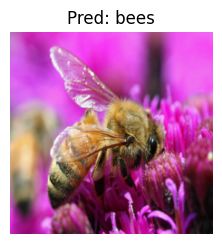

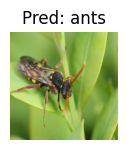

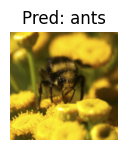

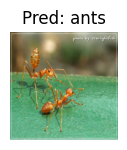

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """把 Tensor 轉回圖片顯示出來"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# 1. 抓一批測試資料
inputs, classes = next(iter(dataloaders['val']))

# 2. 讓模型預測
model.eval() # 設定為評估模式
outputs = model(inputs.to(device))
_, preds = torch.max(outputs, 1)

# 3. 畫出來
print("模型預測結果 (Pred) vs 實際標籤 (Real):")
plt.figure(figsize=(12, 12))
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    ax.axis('off')
    ax.set_title(f'Pred: {class_names[preds[i]]}')
    imshow(inputs[i].cpu())

#預測不在資料集裡的圖片

📸 請點擊下方按鈕上傳圖片 (jpg 或 png)...


Saving b20240919114635.jpg to b20240919114635.jpg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35258 (\N{CJK UNIFIED IDEOGRAPH-89BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24471 (\N{CJK UNIFIED IDEOGRAPH-5F97}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36889 (\N{CJK UNIFIED IDEOGRAPH-9019}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27284 (\N{CJK UNIFIED IDEOGRAPH-6A94}) missing from font(s) DejaVu Sans.
  fig.canvas

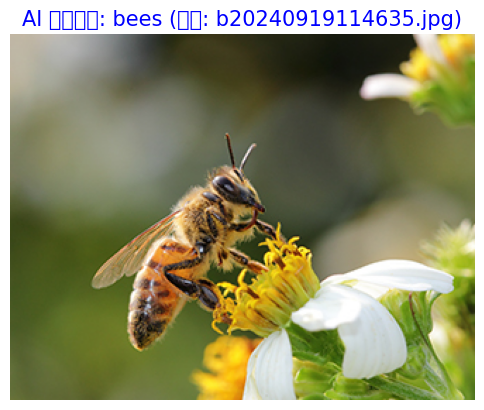

In [10]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import io

# 1. 定義單張圖片的預處理 (必須跟訓練時一模一樣)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("📸 請點擊下方按鈕上傳圖片 (jpg 或 png)...")

# 2. 呼叫 Colab 的上傳功能
uploaded = files.upload()

# 3. 讀取並預測每一張上傳的圖片
for filename in uploaded.keys():
    # 打開圖片
    image = Image.open(io.BytesIO(uploaded[filename])).convert('RGB')

    # 預處理：增加一個維度 (因為模型習慣一次吃一批資料 [Batch, Channel, Height, Width])
    input_tensor = preprocess(image).unsqueeze(0)

    # 搬到 GPU
    input_tensor = input_tensor.to(device)

    # 預測
    model_ft.eval() # 切換到評估模式
    with torch.no_grad():
        output = model_ft(input_tensor)
        _, pred_idx = torch.max(output, 1)

    prediction = class_names[pred_idx.item()]

    # 顯示結果
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.title(f"AI 覺得這是: {prediction} (檔案: {filename})", fontsize=15, color='blue')
    plt.axis('off')
    plt.show()

📸 請點擊下方按鈕上傳圖片 (jpg 或 png)...


Saving C20250910203339630.jpg to C20250910203339630.jpg


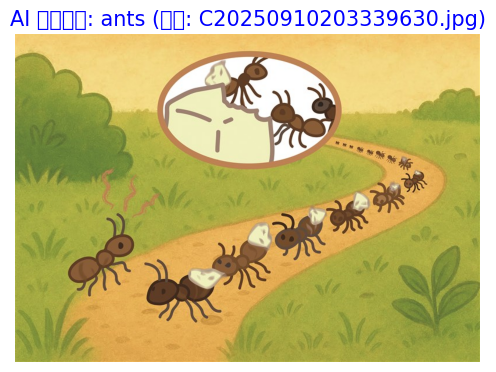

In [11]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import io

# 1. 定義單張圖片的預處理 (必須跟訓練時一模一樣)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("📸 請點擊下方按鈕上傳圖片 (jpg 或 png)...")

# 2. 呼叫 Colab 的上傳功能
uploaded = files.upload()

# 3. 讀取並預測每一張上傳的圖片
for filename in uploaded.keys():
    # 打開圖片
    image = Image.open(io.BytesIO(uploaded[filename])).convert('RGB')

    # 預處理：增加一個維度 (因為模型習慣一次吃一批資料 [Batch, Channel, Height, Width])
    input_tensor = preprocess(image).unsqueeze(0)

    # 搬到 GPU
    input_tensor = input_tensor.to(device)

    # 預測
    model_ft.eval() # 切換到評估模式
    with torch.no_grad():
        output = model_ft(input_tensor)
        _, pred_idx = torch.max(output, 1)

    prediction = class_names[pred_idx.item()]

    # 顯示結果
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.title(f"AI 覺得這是: {prediction} (檔案: {filename})", fontsize=15, color='blue')
    plt.axis('off')
    plt.show()